# Video lifetime performance prediction based on early engagement signals

## I. Exploring the feature set

### Dataset Structure and Feature Overview

This dataset is designed to capture video performance and early engagement signals around platform-specific impression milestones.

Key Feature Groups:
- `video_id`, `channel_name`, `video_length`: basic identifiers and metadata
- `*_1k`: engagement metrics when the video reaches 1,000 impressions (e.g., `views3s_1k`, `like_1k`, `comments_1k`)
- `*_5k`: engagement metrics at the 5,000 impression milestone (e.g., `views3s_5k`, `like_5k`, `comments_5k`)
- `*_final`: final outcome metrics used as regression targets (e.g., `views_final`, `like_final`, `comment_final`)
- `reaches_5k`: boolean flag indicating whether the video truly reached 5k impressions

These features reflect the kind of early-stage metrics typically available in video performance forecasting workflows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# ----- Step 1: Load and Preprocess Data -----
df = pd.read_csv("../data/Video_Timeseries.csv")
df = df.dropna().reset_index(drop=True)
df.shape

(13806, 15)

In [5]:
# Log-transform target to mitigate skewness.
df['log_views_final'] = np.log1p(df['views_final'])

In [ ]:
# ----- Step 2: Define and Scale Feature Sets -----
# Original early engagement features.
orig_features = ['views3s_1k', 'like_1k', 'comments_1k',
                 'views3s_5k', 'like_5k', 'comments_5k']

# Engineer additional rate features.
df['openrate3s_1k'] = np.where(df['impressions_1k'] != 0, df['views3s_1k'] / df['impressions_1k'], 0)
df['openrate3s_5k'] = np.where(df['impressions_5k'] != 0, df['views3s_5k'] / df['impressions_5k'], 0)
df['engrate_1k'] = np.where(df['views3s_1k'] != 0, df['like_1k'] / df['views3s_1k'], 0)
df['engrate_5k'] = np.where(df['views3s_5k'] != 0, df['like_5k'] / df['views3s_5k'], 0)
df['commentratio_1k'] = np.where(df['like_1k'] != 0, df['comments_1k'] / df['like_1k'], 0)
df['commentratio_5k'] = np.where(df['like_5k'] != 0, df['comments_5k'] / df['like_5k'], 0)
eng_features = ['openrate3s_1k', 'openrate3s_5k', 'engrate_1k', 'engrate_5k',
                'commentratio_1k', 'commentratio_5k']

# Combined feature set.
combined_features = orig_features + eng_features

# For better numerical performance, scale the features.
scaler = StandardScaler()
X_combined = scaler.fit_transform(df[combined_features].values)
y_log = df['log_views_final'].values

In [ ]:
# normalizing the early engagement data based on impressions milestones
df['views3s_1k'] = df['views3s_1k'] * 1000 / df['impressions_1k']
df['like_1k'] = df['like_1k'] * 1000 / df['impressions_1k']
df['comments_1k'] = df['comments_1k'] * 1000 / df['impressions_1k']
df['views3s_5k'] = df['views3s_5k'] * 1000 / df['impressions_5k']
df['like_5k'] = df['like_5k'] * 1000 / df['impressions_5k']
df['comments_5k'] = df['comments_5k'] * 1000 / df['impressions_5k']

# drop the impressions columns
# df = df.drop(columns=['impressions_1k', 'impressions_5k'])
df.head()

,video_id,channel_id,video_length,views_final,impressions_final,like_final,comment_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,impressions_5k,like_5k,comments_5k
0,58006937d7695b285f9854bf86a0d63a1476f578925275...,bab3e0fb356b5dab60dfbfbc33a611547250e93830f6f0...,785,60904.0,96520.0,1094.0,51.0,511.206897,1160,19.827586,2.586207,596.423249,6710.0,18.926975,1.639344
1,91423a16a2a5fc24cda7bd93403c52f1198dfb7a62ad0c...,cd0c9afcf7a1c5c5f2e80747041df16c661074594493a1...,412,130986.0,286634.0,760.0,116.0,240.631114,39359,4.700323,0.177850,240.631114,39359.0,4.700323,0.177850
2,ac4f4163917b5bb69c1b227a075817a830ee8afc93bef6...,7687f7c22713a0ba4ce088fb9b5c32a2d9c03567759c28...,186,886216.0,1160128.0,29008.0,184.0,861.298224,3266,34.598898,0.612370,687.222159,8773.0,30.890231,0.569930
3,061287596b4a02efaff23eacba6fc9ee2d31b6f6daebd6...,a45ac131cbca37a25a5527b76bb9910cc4ee9689670af0...,338,534100.0,1006887.0,7151.0,165.0,559.621411,31591,15.637365,0.854674,559.621411,31591.0,15.637365,0.854674
4,4250d891dfeba257ef2367c37e29865b4555120d26aa43...,29a69f4cd31f2c5a88e7a5e16a621e8d2d3fd2971cbadb...,400,203323.0,382255.0,2174.0,351.0,575.481611,2855,4.203152,1.050788,429.826764,7966.0,3.514938,1.506402


## II. Exploring the target distribution

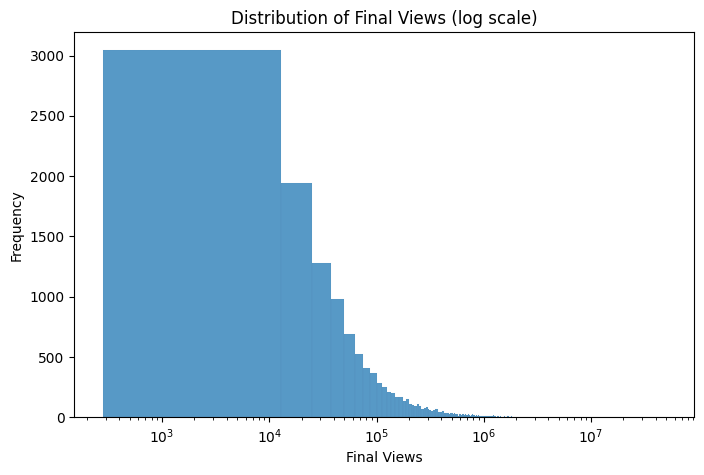

In [8]:
# Histogram of final views
plt.figure(figsize=(8, 5))
sns.histplot(df['views_final'])
plt.xscale("log")
plt.title("Distribution of Final Views (log scale)")
plt.xlabel("Final Views")
plt.ylabel("Frequency")
plt.show()

## III. Testing which features are tied closely to final outcome with correlations

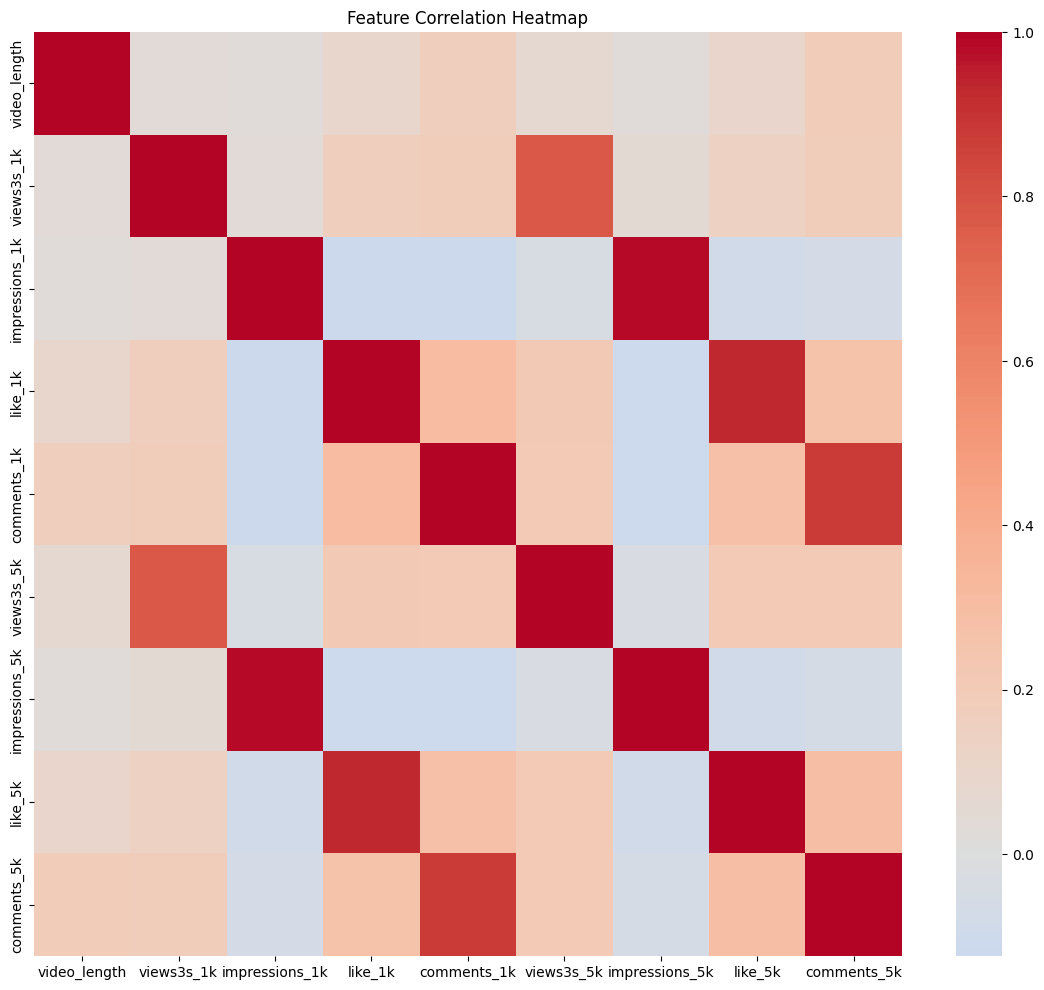

In [9]:
# Feature correlation heatmap
numeric_cols = [col for col in df.columns if df[col].dtype != 'object' and 'final' not in col]
corr = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

## IV. Training a regression model

### Initial Model Training: Baseline Approach

We begin with a single Random Forest model trained on log-transformed `views_final`. This gives us a baseline against which to compare more advanced techniques like lifespan-aware modeling.

In [10]:
# Train a basic regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [11]:
# Select early features
features = [
    'views3s_1k', 'like_1k', 'comments_1k',
    'views3s_5k', 'like_5k', 'comments_5k',
    # 'video_length'
]

In [12]:
# Create X and y and split the data
import numpy as np

X = df[features]
y_log = np.log1p(df['views_final'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [13]:
# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Evaluate
mae = mean_absolute_error(y_test, model.predict(X_test))
mape = mean_absolute_percentage_error(y_test, model.predict(X_test))

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.4f}")

MAE: 1.22
MAPE: 0.1137


## V. Introduce cluster-specific modelling

In [19]:
# engineering velocity features for clustering

df['velocity_1'] = df['impressions_1k'] / 1000
df['velocity_5'] = df['impressions_5k'] / df['impressions_1k']

In [21]:
from sklearn.cluster import KMeans

# We create two velocity features.
# velocity_1 = impressions_1k normalized by 1000.
df['velocity_1'] = df['impressions_1k'] / 1000.0
# velocity_5 = impressions_5k / impressions_1k (handle division-by-zero).
df['velocity_5'] = df['impressions_5k'] / df['impressions_1k']

clust_features = ['velocity_1', 'velocity_5']
X_clust = df[clust_features].values

# Perform K-means clustering (using k=3 clusters; adjust if needed).
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_clust)
print("\nCluster counts based on engineered velocity features:")
print(df['cluster'].value_counts())


Cluster counts based on engineered velocity features:
cluster
0    11479
1     1736
2      591
Name: count, dtype: int64


In [22]:
# Train separate models for each lifespan group
models = {}
metrics = {}

for group in df['cluster'].unique():
    group_df = df[df['cluster'] == group]
    X = group_df[features]
    y_log = np.log1p(group_df['views_final'])

    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)

    models[group] = model
    metrics[group] = {'MAE': mae, 'MAPE': mape}

In [24]:
# Compare specialized models
for group, metric in metrics.items():
    print(f"Cluster {group}: MAE = {metric['MAE']:.2f}, MAPE = {metric['MAPE']:.4f}")

Cluster 0: MAE = 242283.33, MAPE = 2.2707
Cluster 1: MAE = 356563.88, MAPE = 2.0435
Cluster 2: MAE = 263131.78, MAPE = 0.9407
